<a href="https://colab.research.google.com/github/saokotie/Applied-Machine-Learning/blob/main/03_skin_disease_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% [setup]
import os, sys, json, random, shutil, zipfile, math, time
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('TensorFlow', tf.__version__)

BASE_DIR = Path('.').resolve()
OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'
MODEL_DIR = OUTPUT_DIR / 'models'
METRIC_DIR = OUTPUT_DIR / 'metrics'

for d in [OUTPUT_DIR, PREP_DIR, MODEL_DIR, METRIC_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Physical GPUs', tf.config.list_physical_devices('GPU'))


2025-10-09 11:14:38.222448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760008478.456912      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760008478.523140      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow 2.18.0
Physical GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %% [data-acquisition]
from pathlib import Path

CANDIDATES = [
    Path('/content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease')
]

DATA_ROOT = None
for p in CANDIDATES:
    if (p/'train').exists() and (p/'test').exists():
        DATA_ROOT = p
        break

if DATA_ROOT is None:
    print('none')
else:
    print('DATA_ROOT =', DATA_ROOT.resolve())
    print('Train dir =', (DATA_ROOT/'train').resolve())
    print('Test dir =', (DATA_ROOT/'test').resolve())

DATA_ROOT = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease
Train dir = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease/train
Test dir = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease/test


In [ ]:
# %% [data-understanding]
import pandas as pd

def scan_split(root_dir: Path):
    items = []
    for cls_dir in sorted([d for d in root_dir.iterdir() if d.is_dir()]):
        label = cls_dir.name
        for img_path in cls_dir.rglob('*'):
            if img_path.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.gif'} and img_path.is_file():
                items.append((img_path, label))
    return pd.DataFrame(items, columns=['filepath','label'])

if DATA_ROOT is not None:
    train_src = DATA_ROOT/'train'
    test_src  = DATA_ROOT/'test'
    df_train_src = scan_split(train_src)
    df_test_src  = scan_split(test_src)

    print('Train images,', len(df_train_src), 'kelas,', df_train_src["label"].nunique())
    print('Test images,', len(df_test_src), 'kelas,', df_test_src["label"].nunique())

    display(df_train_src.head())
    display(df_train_src['label'].value_counts().to_frame('count'))
else:
    df_train_src = pd.DataFrame(columns=['filepath','label'])
    df_test_src = pd.DataFrame(columns=['filepath','label'])

Train images, 13898 kelas, 22
Test images, 1546 kelas, 22


,filepath,label
0,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
1,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
2,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
3,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
4,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne


,count
label,
Unknown_Normal,1651
Benign_tumors,1093
Eczema,1010
Tinea,923
Psoriasis,820
Actinic_Keratosis,748
Vitiligo,714
SkinCancer,693
Acne,593


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

if len(df_train_src) > 0:
    cls_counts = df_train_src['label'].value_counts().sort_values(ascending=False)
    plt.figure()
    cls_counts.plot(kind='barh', figsize=(8, max(3, 0.35*len(cls_counts))))
    plt.xlabel('Number of data')
    plt.ylabel('Disease')
    plt.tight_layout()
    plt.show()


def visualize_samples_df(df, n=5):
    n = min(n, len(df))
    if n == 0:

        return
    rows = df.sample(n=n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, rows.iterrows()):
        try:
            img = Image.open(row['filepath']).convert('RGB')
            ax.imshow(img)
            ax.set_title(str(row['label']))
            ax.axis('off')
        except Exception as e:
            ax.axis('off')
            ax.set_title('Gagal load')
    plt.tight_layout()
    plt.show()

visualize_samples_df(df_train_src, n=5)

NameError: name 'df_train_src' is not defined

In [ ]:
# %% [preprocess]
from sklearn.model_selection import train_test_split
from PIL import Image
import zipfile, shutil
from pathlib import Path

IMG_SIZE = (224, 224)
VAL_SIZE = 0.15
BATCH_SIZE = 32

assert 'df_train_src' in globals() and len(df_train_src) > 0, "df_train_src belum tersedia"
assert 'df_test_src'  in globals(), "df_test_src belum tersedia"

OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'

shutil.rmtree(PREP_DIR, ignore_errors=True)
PREP_DIR.mkdir(parents=True, exist_ok=True)

train_df, val_df = train_test_split(
    df_train_src,
    test_size=VAL_SIZE,
    stratify=df_train_src['label'],
    random_state=42
)

def save_resized(df_split, split_name):
    split_dir = PREP_DIR / split_name
    for _, row in df_split.iterrows():
        src = Path(row['filepath'])
        label = str(row['label']) if 'label' in row else src.parent.name
        dst_dir = split_dir / label
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / src.name
        try:
            img = Image.open(src).convert('RGB')
            img = img.resize(IMG_SIZE, Image.BILINEAR)
            img.save(dst)
        except Exception:
            pass

save_resized(train_df, 'train')
save_resized(val_df,   'val')
save_resized(df_test_src, 'test')

print('Sumber Train asli,', len(df_train_src), 'gambar')
print('Split baru,', len(train_df), 'train,', len(val_df), 'val,', len(df_test_src), 'test')

zip_path = OUTPUT_DIR / 'skindisease_preprocessed.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for p in PREP_DIR.rglob('*'):
        if p.is_file():
            zf.write(p, p.relative_to(OUTPUT_DIR))
print('Arsip preprocessed,', zip_path.resolve())

Sumber Train asli, 13898 gambar
Split baru, 11813 train, 2085 val, 1546 test
Arsip preprocessed, /kaggle/working/outputs/skindisease_preprocessed.zip


In [2]:
# %% [pipeline]
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from pathlib import Path

OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=None
)

base_gen = ImageDataGenerator(preprocessing_function=None)

def make_generators(preprocess_fn):
    train_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_fn
    )
    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_gen  = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_flow = train_gen.flow_from_directory(
        PREP_DIR/'train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_flow = valid_gen.flow_from_directory(
        PREP_DIR/'val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    test_flow = test_gen.flow_from_directory(
        PREP_DIR/'test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_flow, val_flow, test_flow

if (PREP_DIR/'train').exists():
    tmp_flow = ImageDataGenerator().flow_from_directory(PREP_DIR/'train', target_size=IMG_SIZE, batch_size=32, class_mode='categorical')
    class_indices = tmp_flow.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    with open(OUTPUT_DIR/'class_indices.json', 'w') as f:
        json.dump({'class_indices': class_indices, 'inv_class_indices': inv_class_indices}, f, indent=2)
    print('class_indices', class_indices)
else:
    class_indices = {}
    inv_class_indices = {}

In [ ]:
# %% [modeling-utils]
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

OUTPUT_DIR = Path('./outputs')
MODEL_DIR = OUTPUT_DIR / 'models'
METRIC_DIR = OUTPUT_DIR / 'metrics'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRIC_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def build_optimized_model(model_name, input_shape, n_classes):
    """Build optimized model with better architecture for faster training and better accuracy"""
    inputs = layers.Input(shape=input_shape + (3,))

    if model_name == 'resnet50':
        base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')
        preprocess_fn = resnet_preprocess
    elif model_name == 'efficientnetb0':
        base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')
        preprocess_fn = efficientnet_preprocess
    else:
        raise ValueError('Unknown model name')

    base.trainable = True
    total_layers = len(base.layers)
    freeze_until = int(0.75 * total_layers)
    for i, layer in enumerate(base.layers):
        if i < freeze_until:
            layer.trainable = False
        else:
            layer.trainable = True

    x = base.output
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=f'{model_name}_optimized')
    return model, preprocess_fn

def compile_optimized_model(model, lr=1e-3):
    """Compile model with optimized settings"""
    opt = tf.keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def make_generators(preprocess_fn):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    PREP_DIR = Path('./outputs/skindisease_preprocessed')


    train_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.8, 1.2],
        shear_range=0.1,
        fill_mode='nearest',
        preprocessing_function=preprocess_fn
    )

    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_gen  = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_flow = train_gen.flow_from_directory(
        PREP_DIR/'train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_flow = valid_gen.flow_from_directory(
        PREP_DIR/'val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    test_flow = test_gen.flow_from_directory(
        PREP_DIR/'test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_flow, val_flow, test_flow

def plot_training_history(history, model_tag):
    """Plot accuracy and loss charts for training"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history:
        axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_tag} - Training & Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history:
        axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_tag} - Training & Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(METRIC_DIR/f'{model_tag}_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_with_numbers(cm, target_names, model_tag):
    """Plot confusion matrix with numbers annotated in each cell"""
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names,
                cbar_kws={'label': 'Number of Samples'},
                annot_kws={'size': 10, 'weight': 'bold'})

    plt.title(f'Confusion Matrix - {model_tag}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    plt.tight_layout()
    plt.savefig(METRIC_DIR/f'{model_tag}_confusion_matrix_annotated.png', dpi=150, bbox_inches='tight')
    plt.show()

def print_classification_report(cls_report, model_tag):
    """Print formatted classification report"""
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT - {model_tag.upper()}")
    print(f"{'='*60}")

    report_df = pd.DataFrame(cls_report).transpose()

    metrics_to_show = ['precision', 'recall', 'f1-score', 'support']
    display_cols = [col for col in metrics_to_show if col in report_df.columns]

    print("\nDetailed Report:")
    display(report_df[display_cols].round(4))

    if 'accuracy' in cls_report:
        print(f"\nOverall Accuracy: {cls_report['accuracy']:.4f}")


    if 'macro avg' in cls_report:
        macro_avg = cls_report['macro avg']
        print(f"\nMacro Average:")
        print(f"  Precision: {macro_avg['precision']:.4f}")
        print(f"  Recall:    {macro_avg['recall']:.4f}")
        print(f"  F1-Score:  {macro_avg['f1-score']:.4f}")

    if 'weighted avg' in cls_report:
        weighted_avg = cls_report['weighted avg']
        print(f"\nWeighted Average:")
        print(f"  Precision: {weighted_avg['precision']:.4f}")
        print(f"  Recall:    {weighted_avg['recall']:.4f}")
        print(f"  F1-Score:  {weighted_avg['f1-score']:.4f}")

def train_optimized_model(model, preprocess_fn, model_tag, epochs=30, lr=1e-3):
    """Single-phase optimized training for better accuracy and faster convergence"""
    train_flow, val_flow, test_flow = make_generators(preprocess_fn)
    n_classes = train_flow.num_classes


    model = compile_optimized_model(model, lr=lr)


    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            str(MODEL_DIR/f'{model_tag}_best.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]

    print(f"Starting optimized training for {model_tag}...")
    print(f"Training samples: {train_flow.samples}")
    print(f"Validation samples: {val_flow.samples}")
    print(f"Test samples: {test_flow.samples}")
    print(f"Number of classes: {n_classes}")

    history = model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )


    plot_training_history(history.history, model_tag)

    test_results = model.evaluate(test_flow, verbose=0)
    test_loss = test_results[0]
    test_accuracy = test_results[1]

    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    test_flow.reset()
    y_prob = model.predict(test_flow, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_flow.classes
    target_names = list(test_flow.class_indices.keys())

    from sklearn.metrics import classification_report, confusion_matrix
    cls_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    pd.DataFrame(history.history).to_csv(METRIC_DIR/f'{model_tag}_training_history.csv', index=False)
    pd.DataFrame(cm, index=target_names, columns=target_names).to_csv(METRIC_DIR/f'{model_tag}_confusion_matrix.csv')
    pd.DataFrame(cls_report).T.to_csv(METRIC_DIR/f'{model_tag}_classification_report.csv')

    results = {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_accuracy),
        'classification_report': cls_report,
        'confusion_matrix': cm.tolist(),
        'target_names': target_names,
        'training_epochs': len(history.history['accuracy']),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1])
    }

    with open(METRIC_DIR/f'{model_tag}_results.json','w') as f:
        json.dump(results, f, indent=2)

    plot_confusion_matrix_with_numbers(cm, target_names, model_tag)

    print_classification_report(cls_report, model_tag)

    model.save(MODEL_DIR/f'{model_tag}_final.keras')
    print(f"\nModel saved as: {MODEL_DIR/f'{model_tag}_final.keras'}")

    return model, results

Found 11813 images belonging to 22 classes.
Model Architecture Summary:


Model: "resnet50_optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,776,854 (94.52 MB)

 Trainable params: 17,282,326 (65.93 MB)

 Non-trainable params: 7,494,528 (28.59 MB)

Found 11813 images belonging to 22 classes.
Found 2085 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.
Starting optimized training for resnet50_optimized...
Training samples: 11813
Validation samples: 2085
Test samples: 1546
Number of classes: 22
Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2297 - loss: 4.0585
Epoch 1: val_accuracy improved from -inf to 0.36403, saving model to outputs/models/resnet50_optimized_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 222s 506ms/step - accuracy: 0.2299 - loss: 4.0575 - val_accuracy: 0.3640 - val_loss: 5.1250 - learning_rate: 0.0010
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.3958 - loss: 2.9795
Epoch 2: val_accuracy improved from 0.36403 to 0.45420, saving model to outputs/models/resnet50_optimized_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 170s 460ms/step - accuracy: 0.3958 - loss: 2.9792 - val_accuracy: 0.4542 - val_loss: 2.5973 - learning_rate: 0.0010
Epoch 3/20
370/370 ━━━━━━━━━━

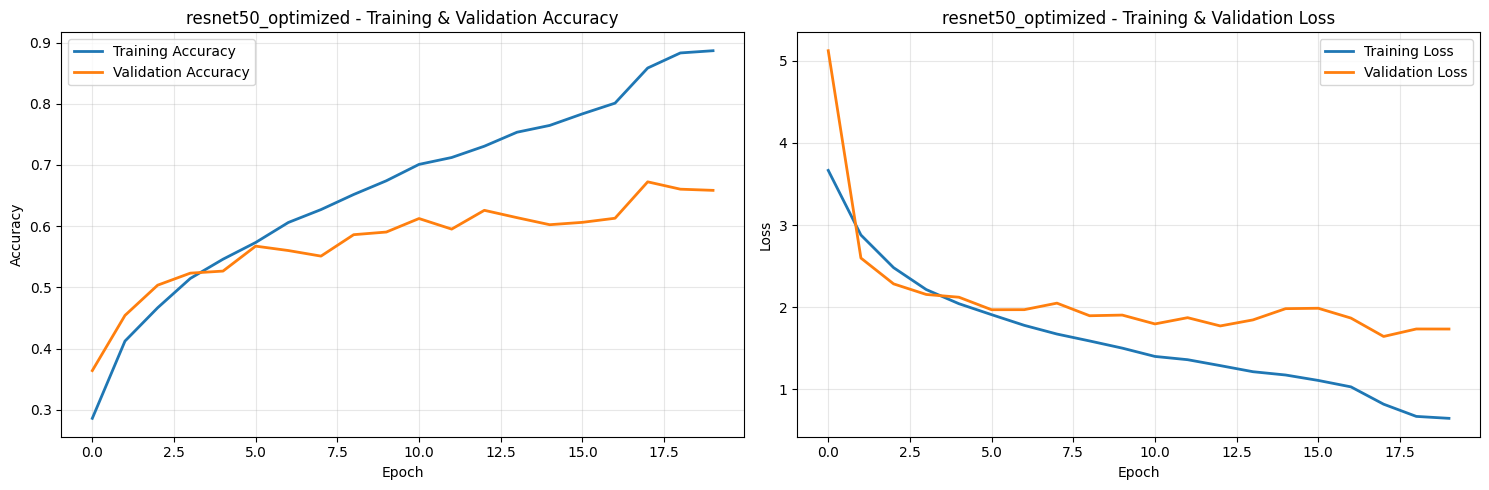


Test Accuracy: 0.6759
Test Loss: 1.6463


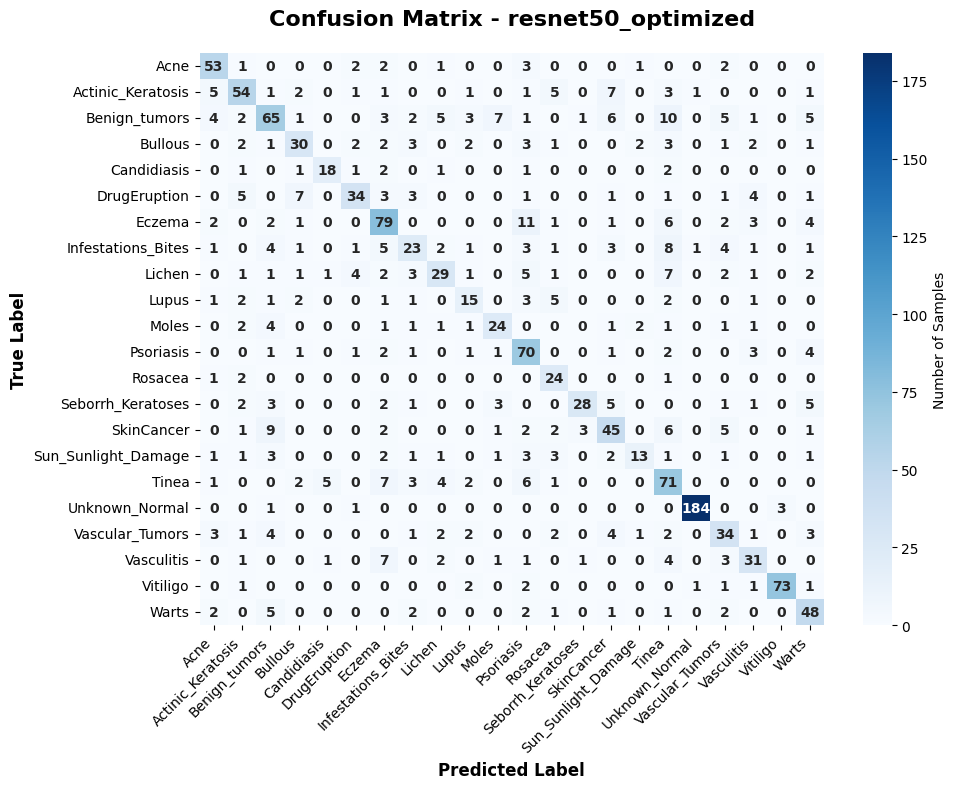


CLASSIFICATION REPORT - RESNET50_OPTIMIZED

Detailed Report:


,precision,recall,f1-score,support
Acne,0.7162,0.8154,0.7626,65.0000
Actinic_Keratosis,0.6835,0.6506,0.6667,83.0000
Benign_tumors,0.6190,0.5372,0.5752,121.0000
Bullous,0.6122,0.5455,0.5769,55.0000
Candidiasis,0.7200,0.6667,0.6923,27.0000
DrugEruption,0.7234,0.5574,0.6296,61.0000
Eczema,0.6423,0.7054,0.6723,112.0000
Infestations_Bites,0.5111,0.3833,0.4381,60.0000
Lichen,0.6042,0.4754,0.5321,61.0000
Lupus,0.4839,0.4412,0.4615,34.0000



Overall Accuracy: 0.6759

Macro Average:
  Precision: 0.6546
  Recall:    0.6372
  F1-Score:  0.6372

Weighted Average:
  Precision: 0.6837
  Recall:    0.6759
  F1-Score:  0.6735

Model saved as: outputs/models/resnet50_optimized_final.keras

Final Test Accuracy: 0.6759
Training completed in 20 epochs


In [ ]:
# %% [train-resnet50]
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

PREP_DIR = Path('./outputs/skindisease_preprocessed')
IMG_SIZE = (224,224)

if (PREP_DIR/'train').exists():
    tmp_flow = ImageDataGenerator().flow_from_directory(PREP_DIR/'train', target_size=IMG_SIZE, batch_size=1, class_mode='categorical')
    n_classes = tmp_flow.num_classes
else:
    n_classes = 2

resnet_model, resnet_prep = build_optimized_model('resnet50', IMG_SIZE, n_classes)
print("Model Architecture Summary:")
resnet_model.summary()

resnet_model, resnet_results = train_optimized_model(
    resnet_model,
    resnet_prep,
    model_tag='resnet50_optimized',
    epochs=20,
    lr=1e-3
)

print(f"\nFinal Test Accuracy: {resnet_results['test_accuracy']:.4f}")
print(f"Training completed in {resnet_results['training_epochs']} epochs")